# Data Loading

In [1]:
import sys
from omegaconf import OmegaConf, DictConfig
from typing import Union, Dict, Optional
from pathlib import Path
from experiments.evaluation.utils import recover_traincfg_from_wandb

sys.path.append("../..")

folders_eval = [
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-12-22/12-33-40",
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-12-22/15-12-06",
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-12-23/09-19-32"
]

replacements_bounds = {
    "[0.9, 1.1]": 0.1,
    "[0.75, 1.25]": 0.25,
    "[0.5, 1.5]": 0.5,
}
key_interval = "$\Delta_{rel}$"
key_visibility = "visibility"
key_performance = "return"


from rich import print as printr
from rich.progress import track
import pickle
from pathlib import Path
import numpy as np
import ast
import pandas as pd
from tqdm import tqdm
from wandb.sdk.wandb_helper import parse_config
from experiments.common.utils.json_utils import lazy_json_load
from experiments.evaluation.run_evaluation import find_multirun_paths


def load_wandb_table(fn: Union[str, Path]) -> pd.DataFrame:
    data = lazy_json_load(fn)
    data = pd.DataFrame(data=np.array(data["data"]), columns=data["columns"])
    return data


reload_rpc: bool = False

fn_config = ".hydra/config.yaml"
fn_wbsummary = "wandb/latest-run/files/wandb-summary.json"
fn_wbconfig = "wandb/latest-run/files/config.yaml"

dfs = []
for folder_eval in folders_eval:
    printr(f"Loading from {folder_eval}")
    rpc_fn = Path("rpc" + Path(folder_eval).name + ".csv")
    if not rpc_fn.is_file():
        reload_rpc = True

    paths = find_multirun_paths(result_dir=folder_eval)

    if reload_rpc:
        rpc_list = []
        for i, p in tqdm(enumerate(paths), total=len(paths)):
            p = Path(p)
            fn_cfg = p / fn_config
            fn_wbsum = p / fn_wbsummary
            fn_wbcfg = p / fn_wbconfig
            if not fn_wbcfg.is_file() or not fn_wbsum.is_file() or not fn_cfg.is_file():
                continue
            cfg = OmegaConf.load(fn_cfg)
            traincfg = recover_traincfg_from_wandb(fn_wbcfg)
            summary = lazy_json_load(fn_wbsum)

            if "average_return" in summary:
                average_return = summary["average_return"]
            else:
                average_return = None

            if average_return is None:
                continue

            entry = {
                "average_return": average_return,
            }

            path_to_table = fn_wbsum.parent / summary["return_per_context_table"]["path"]
            return_per_context = load_wandb_table(path_to_table)

            # Sort by context id so we can add repetition info
            return_per_context.sort_values(by="context_id", inplace=True)
            n_contexts = return_per_context["context_id"].nunique()
            n_reps = len(return_per_context) // n_contexts
            assert n_contexts * n_reps == len(return_per_context)
            repetitions = np.concatenate([np.arange(0, n_reps)] * n_contexts)
            return_per_context["rep"] = repetitions

            contexts_path = fn_wbsum.parent / summary["evalpost/contexts"]["path"]
            contexts = load_wandb_table(contexts_path)

            visibility = traincfg.wandb.group

            context_ids = return_per_context["context_id"].apply(int).to_list()
            contexts_to_table = pd.DataFrame([contexts.iloc[cidx] for cidx in context_ids])
            for col in contexts_to_table.columns:
                return_per_context[col] = contexts_to_table[col].to_numpy()
            n = len(return_per_context)
            # return_per_context["average_return"] = [average_return] * n
            return_per_context[key_visibility] = visibility
            return_per_context[key_interval] = replacements_bounds[str(traincfg.context_sampler.uniform_bounds_rel)]
            return_per_context["context_sampler.context_feature_names"] = str(traincfg.context_sampler.context_feature_names)
            return_per_context["seed"] = traincfg.seed
            return_per_context["algorithm"] = traincfg.algorithm
            rpc_list.append(return_per_context)

            # if i == 10:
            #     break

    if reload_rpc:
        if len(rpc_list) == 0:
            printr("Folder is empty")
            continue
        df_rpc = pd.concat(rpc_list)
        df_rpc.to_csv(rpc_fn)
    else:
        df_rpc = pd.read_csv(rpc_fn)
    dfs.append(df_rpc)

df_rpc = pd.concat(dfs).reset_index(drop=True)
df_rpc.sort_values(by=key_visibility, inplace=True)

Loading from /home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-12-22/12-33-40

Loading from /home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-12-22/15-12-06

Loading from /home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-12-23/09-19-32

# Boxplots

Index(['Unnamed: 0', 'context_id', 'return', 'dt', 'g', 'initial_angle_max',
       'initial_velocity_max', 'l', 'm', 'max_speed', 'average_return',
       'visibility', '$\Delta_{rel}$', 'context_sampler.context_feature_names',
       'seed'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


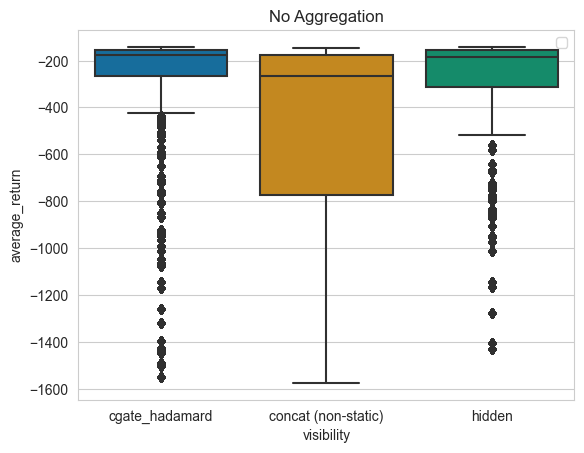

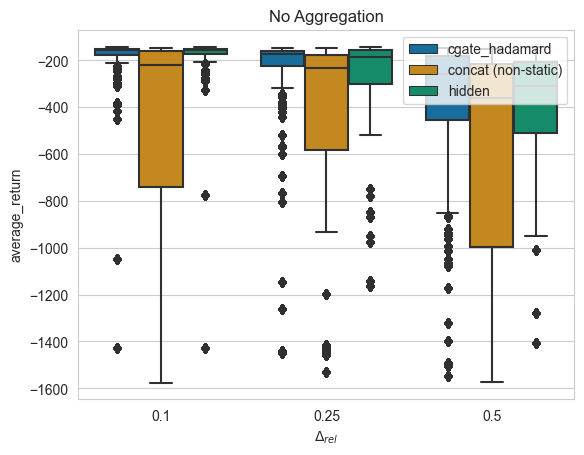

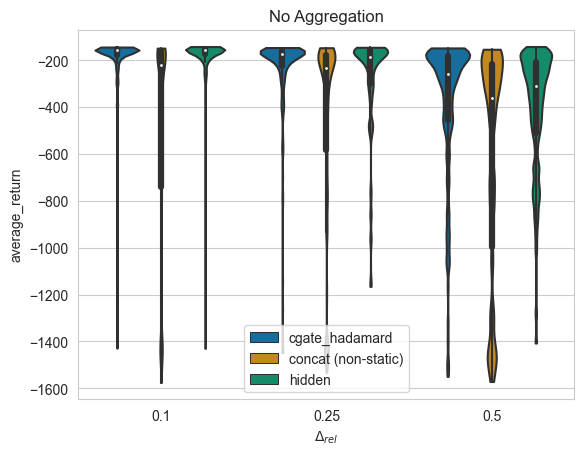

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


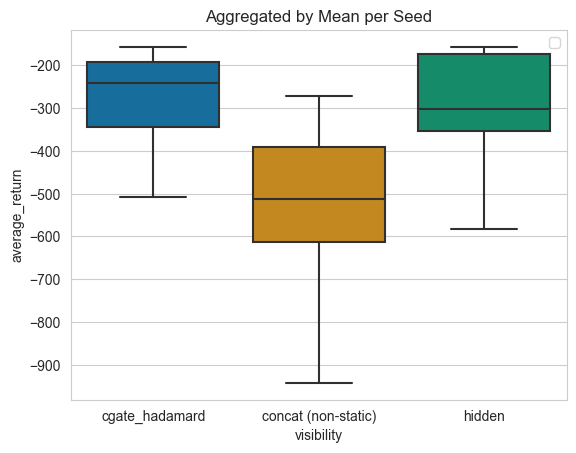

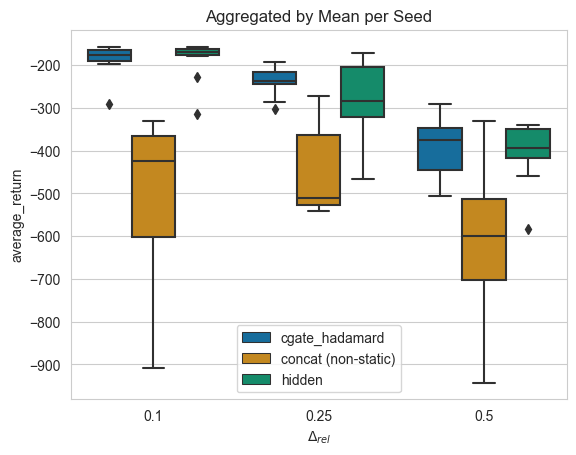

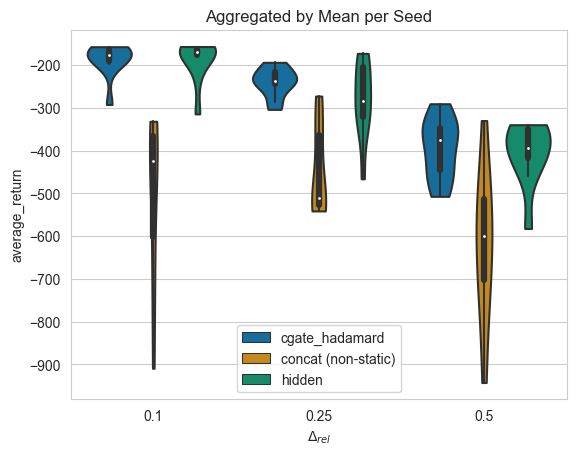

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


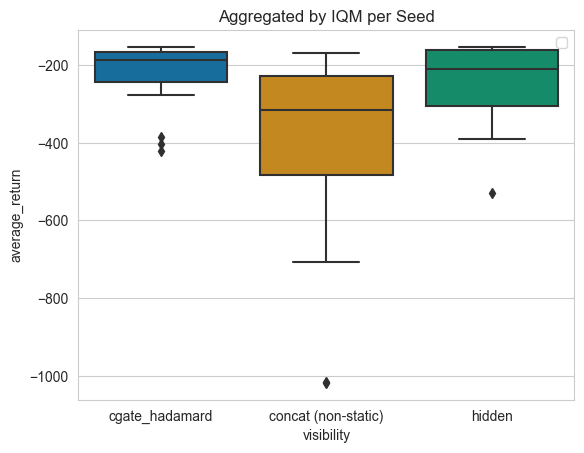

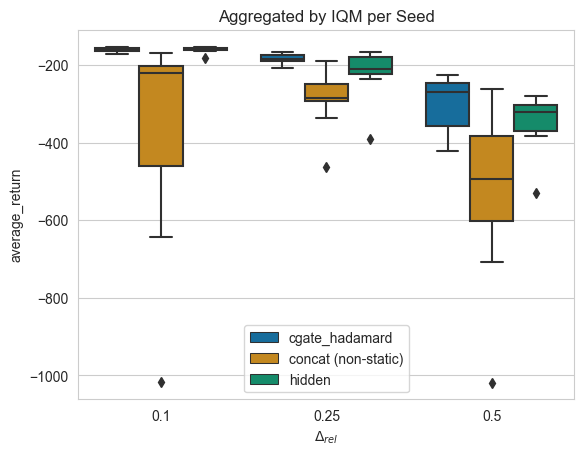

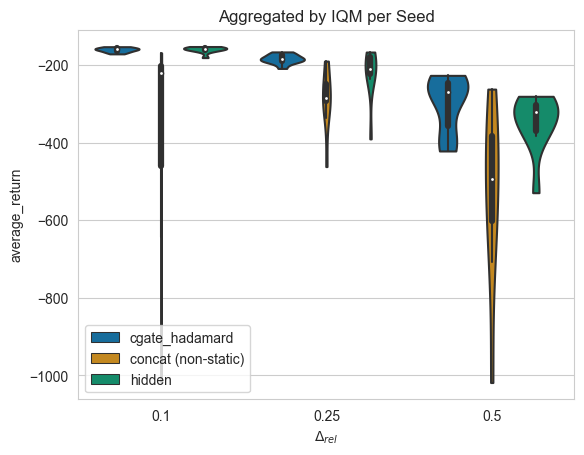

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy


sns.set_palette("colorblind")
sns.set_style("whitegrid")

printr(df_rpc.columns)
key = key_visibility
data = df_rpc[(df_rpc[key] == "hidden") | (df_rpc[key] == "cgate_hadamard") | (df_rpc[key] == "concat (non-static)")]

# All data points
hue = key_visibility
x = key_interval
y = key_performance


title = "No Aggregation"

ax = sns.boxplot(data=data, x=hue, y=y, hue=None)
ax.legend()
ax.set_title(title)
plt.show()

ax = sns.boxplot(data=data, x=x, y=y, hue=hue)
ax.legend()
ax.set_title(title)
plt.show()

ax = sns.violinplot(data=data, x=x, y=y, hue=hue, multiple="dodge", cut=0)
ax.legend()
ax.set_title(title)
plt.show()


# Averaging first
title = "Aggregated by Mean per Seed"

reduced = data.groupby([key_visibility, key_interval, "seed"])[key_performance].mean(numeric_only=True)
# reduced = data.groupby([key_visibility, key_interval, "seed"])[key_performance].apply(scipy.stats.trim_mean, proportiontocut=0.25, axis=None)
reduced = reduced.reset_index()  # multi-index (groups) back to normal columns
df = reduced

ax = sns.boxplot(data=df, x=hue, y=y, hue=None)
ax.legend()
ax.set_title(title)
plt.show()

ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
ax.legend()
ax.set_title(title)
plt.show()

ax = sns.violinplot(data=df, x=x, y=y, hue=hue, multiple="dodge", cut=0)
ax.legend()
ax.set_title(title)
plt.show()



title = "Aggregated by IQM per Seed"

reduced = data.groupby([key_visibility, key_interval, "seed"])[key_performance].apply(scipy.stats.trim_mean, proportiontocut=0.25, axis=None)
reduced = reduced.reset_index()  # multi-index (groups) back to normal columns
df = reduced

ax = sns.boxplot(data=df, x=hue, y=y, hue=None)
ax.legend()
ax.set_title(title)
plt.show()

ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
ax.legend()
ax.set_title(title)
plt.show()

ax = sns.violinplot(data=df, x=x, y=y, hue=hue, multiple="dodge", cut=0)
ax.legend()
ax.set_title(title)
plt.show()



# IQM

(6400, 30)
Warning! We have more tasks than specified. 60 > 30. Capping.
Warning! We have more tasks than specified. 60 > 30. Capping.
Warning! We have more tasks than specified. 60 > 30. Capping.
Warning! We have more tasks than specified. 60 > 30. Capping.
Warning! We have more tasks than specified. 60 > 30. Capping.
Warning! We have more tasks than specified. 60 > 30. Capping.
Warning! We have more tasks than specified. 60 > 30. Capping.
Warning! We have more tasks than specified. 60 > 30. Capping.
Warning! We have more tasks than specified. 60 > 30. Capping.
Warning! We have more tasks than specified. 60 > 30. Capping.
Warning! We have more tasks than specified. 60 > 30. Capping.
Warning! We have more tasks than specified. 60 > 30. Capping.
Warning! We have more tasks than specified. 60 > 30. Capping.
Warning! We have more tasks than specified. 60 > 30. Capping.
Warning! We have more tasks than specified. 60 > 30. Capping.
Warning! We have more tasks than specified. 60 > 30. Cappin

Calculate interval estimates

Plot interval estimates

(5, 7.5)


NameError: name 'plt' is not defined

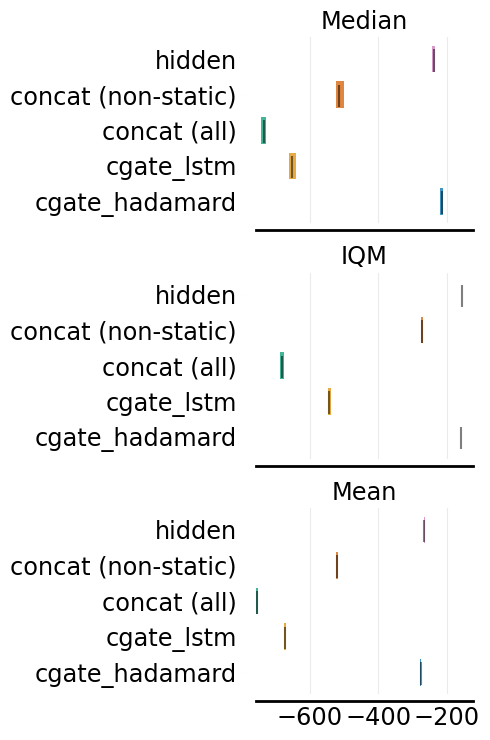

In [21]:
from rliable import library as rly
from rliable import metrics
import importlib
import rliable.plot_utils
importlib.reload(rliable.plot_utils)

fig_fn = "tmp/figures/iqm.png"

data = df_rpc

if "algorithm" in data:
  del data["algorithm"]

reps = 10000
xlabel = ""

metric_names = ['Median', 'IQM', 'Mean']  # , 'Optimality Gap']
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x),
  # metrics.aggregate_optimality_gap(x)
  ])


# Create score matrix
# Scores: (num_points x num_tasks), here:
#         (num_seeds * num_reps x num_tasks)
# Pendulum: num_tasks = n_contexts = 128


# Create score matrix
# Scores: (num_points x num_tasks), here:
# here:
#     num_points = n_contexts * n_seeds * n_reps
#     n_tasks = n_intervals * n_cfs
score_dict = {}
tasks = [key_interval, "context_sampler.context_feature_names"]
points = ["seed", "rep", "context_id"]
for group_id, group_df in data.groupby("visibility"):
  # Determine size of score matrix
  def count(x):
    counts = group_df[x].nunique()
    # print(x, counts)
    return counts
  n_points = np.prod([count(x) for x in points])
  n_tasks = np.prod([count(x) for x in tasks])
  scores = np.zeros((n_points, n_tasks))
  print(scores.shape)
  for i, ((seed, rep, context_id), gdf) in enumerate(group_df.groupby(["seed", "rep", "context_id"])):
    
    # gdf.sort_values(by="context_id", inplace=True)
    n = len(gdf)
    if n > n_tasks:
      print(f"Warning! We have more tasks than specified. {n} > {n_tasks}. Capping.")
      new_df = []
      for sid, sdf in gdf.groupby(tasks):
        # printr(sid, len(sdf), sdf)
        new_df.append(sdf.iloc[np.random.choice(np.arange(0, len(sdf)))])
      gdf = pd.DataFrame(new_df) #.reset_index(drop=True)
      del gdf["Unnamed: 0"]
    elif n < n_tasks:
      print(f"Warning! We have less tasks than specified. {n} > {n_tasks}. Skip.", seed, rep, context_id)
      continue
      # printr(gdf)

    # print(n, seed, rep,)
    # print(gdf[key_interval].nunique(), gdf["context_sampler.context_feature_names"].nunique())
    gdf.sort_values(by="context_sampler.context_feature_names", inplace=True)
    # printr(gdf)
    # index = (seed - 1) * n_seeds + rep  # seed is 1-based
    R = gdf["return"]
    scores[i] = R
  score_dict[group_id] = scores




        


Plot interval estimates

(5, 7.5)


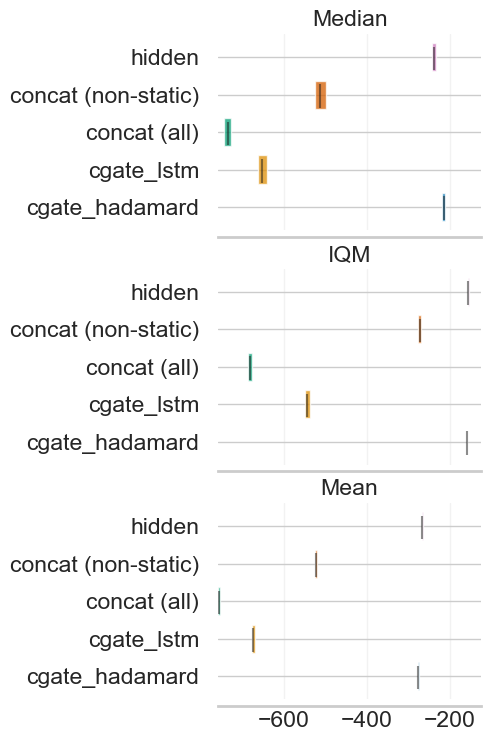

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=0.8)
sns.set_style("whitegrid")

filter_visibilities = ["concat (all)", "cgate_lstm"]
for vis in filter_visibilities:
    if vis in score_dict:
        del score_dict[vis]

printr("Calculate interval estimates")
aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        score_dict, aggregate_func, reps=reps)

printr("Plot interval estimates")
fig, axes = rliable.plot_utils.plot_interval_estimates(
    aggregate_scores, aggregate_score_cis,
    metric_names=metric_names,
    algorithms=list(score_dict.keys()), xlabel=xlabel,
    asrows=True,
    row_height=0.5,
    interval_height=0.75
)
fig.set_tight_layout(True)
fig.savefig(fig_fn, bbox_inches="tight", dpi=300)
plt.show()


24